# Comparison of PyBaMM and COMSOL Discharge Curves

In this notebook we compare the discharge curves obtained by solving the DFN model both in PyBaMM and COMSOL. Results are presented for a range of C-rates, and we see an excellent agreement between the two implementations. If you would like to compare internal variables please see the script [compare_comsol_DFN](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/scripts/compare_comsol/compare_comsol_DFN.py) which creates a slider plot comparing potentials and concentrations as functions of time and space for a given C-rate. For more information on the DFN model, see the [DFN notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/models/DFN.ipynb).

First we need to import pybamm, and then change our working directory to the root of the pybamm folder.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import json
import matplotlib.pyplot as plt

os.chdir(pybamm.__path__[0] + "/..")

Note: you may need to restart the kernel to use updated packages.


We then create a dictionary of the C-rates we would like to solve for and compare. Note that the repository currently only contains COMSOL results for the C-rates listed below. 

In [2]:
C_rates = {"01": 0.1, "05": 0.5, "1": 1, "2": 2, "3": 3}

We get the DFN model equations, geometry, and default parameters. Before processing the model, we adjust the electrode height and depth to be 1 m, and also adjust the electrode conductivities, to match the one-dimensional model we solved in COMSOL. The model is then processed using the default geometry and updated parameters. Finally, we create a mesh and discretise the model. 

In [3]:
# load model and geometry
model = pybamm.lithium_ion.DFN()
geometry = model.default_geometry

# load parameters and process model and geometry
param = model.default_parameter_values
param.update(
    {
        "Electrode width [m]": 1,
        "Electrode height [m]": 1,
        "Negative electrode conductivity [S.m-1]": 126,
        "Positive electrode conductivity [S.m-1]": 16.6,
        "Current function [A]": "[input]",
    }
)
param.process_model(model)
param.process_geometry(geometry)

# create mesh
var_pts = {"x_n": 31, "x_s": 11, "x_p": 31, "r_n": 11, "r_p": 11}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model);

We create the figure by looping over the dictionary of C-rates. In each step of the loop we load the COMSOL results from a .csv file and solve the DFN model in pybamm. The output variables are then processed, allowing us to plot the discharges curve computed using pybamm and COMSOL, and their absolute difference.  

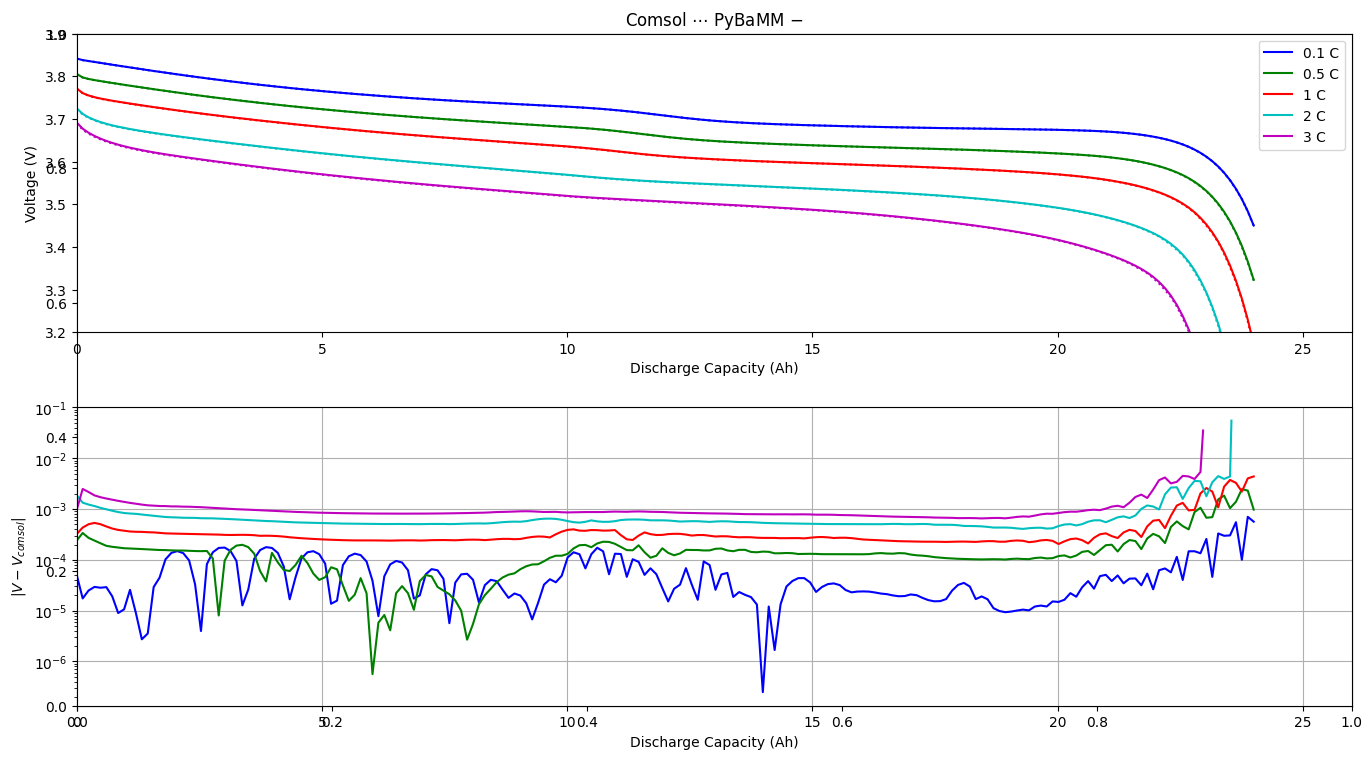

In [7]:
# create figure
fig, ax = plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplots_adjust(left=-0.1)
discharge_curve = plt.subplot(211)
plt.xlim([0, 26])
plt.ylim([3.2, 3.9])
plt.xlabel(r"Discharge Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.title(r"Comsol $\cdots$ PyBaMM $-$")
voltage_difference_plot = plt.subplot(212)
plt.xlim([0, 26])
plt.yscale("log")
plt.grid(True)
plt.xlabel(r"Discharge Capacity (Ah)")
plt.ylabel(r"$\vert V - V_{comsol} \vert$")
colors = iter(plt.cycler(color="bgrcmyk"))

# loop over C_rates dict to create plot
for key, C_rate in C_rates.items():
    # load the comsol results
    comsol_results_path = pybamm.get_parameters_filepath(
        f"input/comsol_results/comsol_{key}C.json",
    )

    comsol_variables = json.load(open(comsol_results_path, "rb"))

    comsol_time = np.array(comsol_variables["time"])
    comsol_voltage = np.array(comsol_variables["voltage"])

    # update current density
    current = 24 * C_rate

    # solve model at comsol times
    solver = pybamm.CasadiSolver(mode="fast")
    solution = solver.solve(
        model, comsol_time, inputs={"Current function [A]": current}
    )
    time_in_seconds = solution["Time [s]"].entries
    # discharge capacity
    discharge_capacity = solution["Discharge capacity [A.h]"]
    discharge_capacity_sol = discharge_capacity(time_in_seconds)
    comsol_discharge_capacity = comsol_time * current / 3600

    # extract the voltage
    voltage = solution["Voltage [V]"]
    voltage_sol = voltage(time_in_seconds)

    # calculate the difference between the two solution methods
    end_index = min(len(time_in_seconds), len(comsol_time))
    voltage_difference = np.abs(voltage_sol[0:end_index] - comsol_voltage[0:end_index])

    # plot discharge curves and absolute voltage_difference
    color = next(colors)["color"]
    discharge_curve.plot(
        comsol_discharge_capacity, comsol_voltage, color=color, linestyle=":"
    )
    discharge_curve.plot(
        discharge_capacity_sol,
        voltage_sol,
        color=color,
        linestyle="-",
        label=f"{C_rate} C",
    )
    voltage_difference_plot.plot(
        discharge_capacity_sol[0:end_index], voltage_difference, color=color
    )

discharge_curve.legend(loc="best")
plt.subplots_adjust(
    top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35
)
plt.show()

## References

The relevant papers for this notebook are:

In [5]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/